<a href="https://colab.research.google.com/github/MiningTheSkies/Full_Waveform_Modeling_Across_Scales/blob/main/2_1D_Wave_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Libraries and Functions

###### Library imports 

In [ ]:
# ----- Import Libraries -----
#-----------------------------
import numpy as np
import pandas as pd
# import itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec

##### Functions

###### 1-D Wave Equation Solver function

In [ ]:
# Define a solver function for the 1-D Wave Equation
# --------------------------------------------------

def wave_solver_1d(c, k, p, L, dt, dx, C, T, DOMAIN, bounds):
    """
    This function will solve a 1-D wave equation of the form
    u_tt = c^2 * u_xx + f on (0,L)x(0,T]
    """
    # define parameters based on function input
    if dt==999: dt=dx
    elif dx==999: dx=dt
    for i in range(len(DOMAIN)-1):
        if c[i]==999: c[i]=np.sqrt(k[i]/p[i])
        elif k[i]==999: k[i]=c[i]**2*p[i]
        elif p[i]==999: p[i]=k[i]/c[i]**2
        if C[i]==999: C[i]=c[i]*dt/dx
    

    Nt = int(round(T/dt))               # number of temporal nodes
    t = np.linspace(0, Nt*dt, Nt+1)     # temporal mesh
    # dx = dt*c/float(C)                  # space-step
    Nx = int(round(L/dx))               # number of spatial nodes
    x = np.linspace(0, L, Nx+1)         # spatial mesh

    # Set parameter mesh in case of heterogeneous - only need to update C since c,k,p values are included in the C array
    C_tmp = np.empty(Nx+1)
    count = 0
    for i in range(Nx+1):
        C_tmp[i] = C[count]
        if i == DOMAIN[count+1]/dx:
            count += 1 

    C2 = C_tmp**2                           # Courant condition - this will return C2 as an array of the same shape as C

    # double check dx & dt compatibility due to potential rounding errors when creating x and t
    dx = x[1]-x[0]
    dt = t[1]-t[0]

    u     = np.zeros(Nx+1)          # future time step (n+1) - this is what we will be solving for
    u_n   = np.zeros(Nx+1)          # current time step (n)
    u_nm1 = np.zeros(Nx+1)          # previous time step (n-1)

    solution_space=np.empty((Nx+1,Nx+1))

    import time; t0 = time.clock()  # we want to measure the CPU time used in order to compare runs/alterations

    # Set initial condition - at *current* time
    for i in range(Nx+1):
        u_n[i] = np.exp(-0.1*(x[i]-50)**2) # take the user-defined initial condition and place it into the current time step

    solution_space[0,:] = u_n
    

    # Set special n+1=1 (n=0) inner mesh - at *future* time
    n = 0
    u[1:-1] = 0.5 * C2[1:-1] * (u_n[:-2] - 2*u_n[1:-1] + u_n[2:]) + u_n[1:-1]         # This is the vectorized version of a for loop would usually be used for
    
    # Set bounds
    for i in range(len(bounds)):                   # this will set both boundaries for both Dirichlet and Neumann cases for all t
        if bounds[i] == "Dirichlet":
            u[-i] = 0
        elif i == 0:
            u[0] = 2 * C2[0] * (u_n[1] - u_n[0]) + 2*u_n[0] - u_nm1[0]
        else:
            u[-1] = 2 * C2[-1] * (u_n[-2] - u_n[-1]) + 2*u_n[-1] - u_nm1[-1]
    

    # Cycle variables to update time-step for new run
    u_nm1, u_n, u = u_n, u, u_nm1   # this is the faster 'switching references' version of vectorization and improves processing efficiency NOTE: u = u_nm1 now so BE CAREFUL!!!

    solution_space[1,:] = u_n

    # Run through the main simulation
    for n in range(1, Nt):          # cycle through each temporal node

        # update inner mesh
        u[1:-1] = C2[1:-1] * (u_n[:-2] - 2*u_n[1:-1] + u_n[2:]) + 2*u_n[1:-1] - u_nm1[1:-1]

        # update bounds ... (same formula as before)
        for i in range(len(bounds)):                   # this will set both boundaries for both Dirichlet and Neumann cases for all t
            if bounds[i] == "Dirichlet":
                u[-i] = 0
            elif i == 0:
                u[0] = 2 * C2[0] * (u_n[1] - u_n[0]) + 2*u_n[0] - u_nm1[0]
            else:
                u[-1] = 2 * C2[-1] * (u_n[-2] - u_n[-1]) + 2*u_n[-1] - u_nm1[-1]
        
        # Cycle variables for next time-step
        u_nm1, u_n, u = u_n, u, u_nm1

        solution_space[n+1,:] = u_n

        if np.any(np.isnan(solution_space[n+1,:])) or np.any(np.isinf(solution_space[n+1,:])):
            solution_space[n+1,:] = n+1; cpu_time = time.clock() - t0
            return solution_space, n

    # reset u to u_n b/c our cycling style leaves it = to u_nm1
    u = u_n
    cpu_time = time.clock() - t0    # calculate the processing time required for the run

    # return solution_space, u, x, t, cpu_time        # return u (which is n+1), space (x) and time (t) arrays, and the processing time
    return solution_space, cpu_time

###### Visualizer function

In [ ]:
def viz(rows, SOLUTION_SPACE):
    rows, cols = rows, SOLUTION_SPACE.shape[0]
    fig = plt.figure(figsize=(24,12))#, sharex=True, sharey=True)
    spec = fig.add_gridspec(nrows=rows, ncols=cols, wspace=.25, hspace=.25)
    plt.suptitle('1-D Homogeneous Wave Equation', fontsize=24, x=.5)
    # fig.text(.5,.925,'1D Heat Equation', fontsize=18, ha='center')

    for row in range(rows):
        for col in range(cols):
            ax = fig.add_subplot(spec[row,col])
            ax.plot(SOLUTION_SPACE[col, row*(int(L/dx/(rows-1))), :])          # L/dx/(rows-1) = 100/.1/10 = 100 but is dynamic for more/less graphs if desired
            plt.ylim(SOLUTION_SPACE[col].min(), SOLUTION_SPACE[col].max())
            # plt.legend(['T = %d' % (row*20)])
            if col == 0:
                plt.ylabel('T = {}'.format(row*(int(L/dx/(rows-1)))), fontsize=12)
            # if row == 0:
            #     ax.set_title(r'$\Delta \, t = %.2f \, \frac{\Delta x^2}{D}$' % (dt[col]), fontsize=16)

    # for ax in fig.get_axes():
    #     ax.label_outer()
    plt.show()

```
Course: GPGN 598B - Full Waveform Modelling Across Scales
Date: Feb. 17, 2020
```
# Numerical Modeling - 1D Wave Equation
---

## Finite Difference Method

The following is what you may need in order to solve this problem set:

\begin{align}
    \partial_t^2 &\approx \frac{f(x,t+\Delta t)-2f(x,t)+f(x,t-\Delta t)}{\Delta t^2} \tag{1}\\
    \partial_x^2 &\approx \frac{f(x+\Delta x,t)-2f(x,t)+f(x-\Delta x,t)}{\Delta x^2} \tag{2}\\
    \partial_x &\approx \frac{f(x+\Delta x,t)-f(x-\Delta x,t)}{2\Delta x} \tag{3}
\end{align}

where $f(x,t)$ is any given field.

## 1) Wave Equation

Discretization of the analytic wave equation

### Given Information

The 1-D expression of the wave equation is:

$$\tag{4}
    \rho(x)\,\partial_t^2u(x,t)=\partial_x[\kappa(x)\,\partial_xu(x,t)], \qquad
    (x\in[0,L],t\in[0,=\infty))
$$

where $u(x,t)$ is the displacement field at the position $x$ at instant $t$, $\rho(x)$ is the material density, and $\kappa(x)$ is the material bulk modulus.

If the material properties are constant, we can write:

$$\tag{5}
    \partial_t^2u(x,t)=c^2\,\partial_x^2u(x,t)
$$

where we have introduced the wavespeed $c$

$$\tag{6}
    c=\sqrt{\frac\kappa\rho}
$$

Initially, let us consider constant material properties, and use the finite difference method to solve the 1-D 'homogeneous' wave equation:

$$
    \partial_t^2u(x,t) = c^2\,\partial_x^2u(x,t)
$$

The initial conditions are:

\begin{align}
    u(x,0) &= e^{-0.1(x-50)^2} \tag{7}\\
    \partial_tu(x,0) &= 0 \tag{8}
\end{align}

We are going to first investigate 2 types of boundary conditions:

- the Dirichlet boundary conditions correspond to a fixed termination, e.g. $u(0,t)=0$ that has no displacement at all times
- the Neumann boundary conditions correspond to a termination free to move, e.g. $T(0,t)=0$



### Work

Let $\rho(x)\,\partial_t^2u(x,t)=\partial_x[\kappa(x)\partial_xu(x,t)]$ represent the wave 1-D wave equation where $x\in[0,L]$ and $t\in[0,+\infty)$. Assuming constant material properties, the wave equation simplifies to $\partial_t^2u(x,t)=c^2\partial_x^2u(x,t)$.

In order to discretize the analytic wave equation, we simply implement equations (1) and (2) into (5), then perform the following operations:

\begin{align}
    \partial_t^2u(x,t)&=c_i^2\partial_x^2u(x,t) \\
    \frac{u_i^{n-1}-2u_i^n+u_i^{n+1}}{\Delta t^2} &= 
        c_i^2\,\frac{u_{i-1}^n-2u_i^n+u_{i+1}^n}{\Delta x^2} \\
    u_i^{n-1}-2u_i^n+u_i^{n+1} &= 
        c_i^2\, \frac{dt^2}{dx^2}\, [u_{i-1}^n-2u_i^n+u_{i+1}^n] \\\\
    u_i^{n+1} &= c_i^2\, \frac{dt^2}{dx^2}\, [u_{i-1}^n-2u_i^n+u_{i+1}^n] +2u_i^n-u_i^{n-1} \tag{9}
\end{align}

Note that this is for $c$ at a particular position $i$.

## 2) First Order System

### Given Information

To solve the wave equation, you can recognize that it is equivalent to

\begin{align}
    \rho(x)\,\partial_tv(x,t) &= \partial_xT(x,t) \tag{10} \\
    \partial_tT(x,t) &= \kappa(x)\,\partial_xv(x,t) \tag{11}
\end{align}

where

\begin{align}
    v(x,t) &= \partial_tu(x,t) \qquad & \text{is a velocity} \tag{12}\\
    T(x,t) &= \kappa(x)\,\partial_xu(x,t) \qquad & \text{is a stress} \tag{13}
\end{align}

Write the discretized form of the system to solve for (1) $(v,T)$ and (2) directly for $u$. The grid size $\Delta x$ is chosen to be $0.1$. The string legnth is $L=100$. Plot your numerical results at several time steps for the following cases

1. $c=1,\; \rho=1,\; \kappa=1 \quad (x\in[0,100])$, Dirichlet boundary conditions on both ends of the string
2. $c=1,\; \rho=1,\; \kappa=1 \quad (x\in[0,100])$, Neumann boundary conditions on both ends of the string

### Work

First, we must discretize (and limit) the domain of the mesh in space and time:

$$
    0 = x_0 < x_1 < ... < x_{N_x-1} < x_{N_x} = L \\
    0 = t_0 < t_1 < ... < t_{N_t-1} < t_{N_t} = T
$$

where $L$ and $T$ represent user-defined values (defaulting to $L=T=100$ in the base case). $\hat{L}$ and $\hat{T}$ will represent the sets of spatial and temporal values such that $i\in \hat{L}$ and $n\in \hat{T}$, where $N_x$ and $N_t$ will represent the maximal values of $L$ and $T$, respectively. Contextually, $L$ and $T$ will also refer to the maximal values, such as $L=T=100$.

>To avoid conflicting notation, $T$ will represent the total time in a simulation while $T_s$ will represent stress. In code, this will be `T` and `T_s` respectively.

In our case, the temporal and spatial meshes are of uniform difference, respectively, so coordinate points such as $u(x,t)$ can be discretized as follows:

$$
    u(x,t) = u(x_i,t_n) = u(\,i\,\Delta x, \,n\,\Delta t), \qquad i=0,1,...,N_x,\, n=0,1,...,N_t
$$

As previously defined in equation (9), the discretized form of the 1-D wave equation with constant material properties is:

$$
    u_i^{n+1} = c_i^2\, \frac{dt^2}{dx^2}\, [u_{i-1}^n-2u_i^n+u_{i+1}^n] +2u_i^n-u_i^{n-1}
$$

Additionally, let $C$ represent $c\frac{\Delta t}{\Delta x}$, such that:
$$
    C = c\frac{\Delta t}{\Delta x} \\
    C^2 = c^2\frac{\Delta t^2}{\Delta x^2},
$$

leading to:

$$
    u_i^{n+1} = C^2\, [u_{i-1}^n-2u_i^n+u_{i+1}^n] +2u_i^n-u_i^{n-1} \tag{14},
$$

where $C$ represents the Courant number of the wave equation.


To rewrite the wave equation (5) in terms of $(v,T)$, we use equations (10-13) as follows:

\begin{align}
    \rho(x)\,\partial_t^2u(x,t) &= \partial_x[\kappa(x)\,\partial_xu(x,t)] \\
    \rho(x)\,\partial_tv(x,t) &= \partial_xT(x,t)
\end{align}

```
    Note: Equation (10) is perfectly fine but I am unsure how to implement equation (11).
It seems incorrect to me since it does not contain any p, and the k's cancel out, resulting in there
not being a phase velocity included.
```

We shall define and discretize the initial conditions for $I(x)$ as follows:


\begin{align} 
    I(x)\; (\forall\, i\in \hat{L}) =
    \begin{cases}
        u(x,0) &= u_i^0 &= e^{-0.1(x-50)^2} \\~\\
        \partial_tu(x,0) &= \partial_tu_i^0 &= 0 \\
        v(x,0) &= v_i^0 &= 0
    \end{cases}
\end{align}

The bottom two conditions are equivalent and useful for defining the initial time-step $u_i^1 \; \forall\,i\in \hat{L}$. This is very important as the $u_i^0$ case, using the centered difference method, requires using $u_i^{-1}$ (using equation (3) for $\partial_t$), which is outside of the considered temporal domain, as seen below:

$$
    \partial_tu(x_i,t_0)\approx\frac{u_i^1-u_i^{-1}}{2\Delta t}
$$

Given that we already know the initial condition of $\partial_tu_i^0=I(x)=0$, we can rework the above equation to:

\begin{align}
    \partial_tu_i^0 &\approx \frac{u_i^1-u_i^{-1}}{2\Delta t} \\
    0 &= \frac{u_i^1-u_i^{-1}}{2\Delta t} \\
    u_i^{-1} &= u_i^1
\end{align}

which, when $n=0$ and we're solving for $n+1$ (i.e. $u_1^1$) using equation (14), results in:

\begin{align}
    u_i^{1} &= C^2\, [u_{i-1}^0-2u_i^0+u_{i+1}^0] + 2u_i^0-\bf{u_i^{-1}} \\
    u_i^{1} &= C^2\, [u_{i-1}^0-2u_i^0+u_{i+1}^0] + 2u_i^0-\bf{u_i^{1}} \\
    2u_i^{1} &= C^2\, [u_{i-1}^0-2u_i^0+u_{i+1}^0] + 2u_i^0 \\
    u_i^{1} &= \frac12 C^2\, [u_{i-1}^0-2u_i^0+u_{i+1}^0] + u_i^0 \tag{15}
\end{align}

Similarly to the initial condition when $N=0$, looking at the boundary conditions, we must perform the same trick with $\partial_x$ when $i=0$ and $i=N_x$ where $T(0,t)=0$.

\begin{align}
    T(0,t_n) &= \kappa(0)\,\partial_xu(0,t_n) \\
    \kappa(0)\,\partial_xu(0,t_n) &\approx \frac{u_{1}^n-u_{-1}^n}{2\Delta x} \\
    0 &= \frac{u_{1}^n-u_{-1}^n}{2\Delta x} \\
    u_{-1}^n &= u_1^n \\
\end{align}

However, implementation of the above equation into equation (14) is not necessarily as quick and easy as the initial condition.

<!-- Following the same steps that led to equation (15) yields

\begin{align}
    u_0^{n+1} &= C^2\, [\boldsymbol{u_{-1}^0}-2u_0^n+u_{1}^n] + 2u_0^n-u_0^{n-1} \\
    u_0^{n+1} &= C^2\, [\boldsymbol{u_1^0}-2u_0^n+u_{1}^n] + 2u_0^n-u_0^{n-1} \\
    u_0^{n+1} &= C^2\, [-u_0^n+u_{1}^n] + 2u_0^n-u_0^{n-1}
\end{align}


This is the only point in the mesh, other than the boundaries, that we need to do anything beyond the scope of equation (14). The boundary conditions will be:

\begin{align}
    u(0,t) &= 
\end{align} -->


Unlike the Dirichlet boundary condition which is a fixed value condition, the Neumann boundary condition is a differential condition which must be taken care. The Neumann boundary

\begin{equation}
    T(0,t) = \kappa(0)\frac{du}{dx}\Bigr|_{x=N_x} = \frac{du}{dx}\Bigr|_{x=N_x} = 0
\end{equation}

must be discretized in such a manner that it can also be plugged into the general mesh equation, such as we did with the initial condition. To accurately discretize it, we will use the $u_{N_x}$ case and look at the difference between $N_x$ and $N_x-1$ by using a backward Taylor series expansion (i.e using $u_{N_x}$ to solve for $u_{(N_x-1)}$).

\begin{equation}
    u_{(N_x-1)} = u_{N_x}-\Delta x\frac{du}{dx}\Bigr|_{N_x} +
        \frac{\Delta x^2}{2!}\frac{d^2u}{dx^2}\Bigr|_{N_x} -
        \frac{\Delta x^3}{3!}\frac{d^3u}{dx^3}\Bigr|_{N_x} + ...
\end{equation}

Since we already know $\frac{du}{dx}=0$, we can plug it in and then rewrite the equation in order to find the $\frac{d^2u}{dx^2}$ term since this is what matches our general mesh equation (because it is second-order). However, in order to solve the general case, we will solve using an arbitrary term $Q$ instead of $0$ such that $\frac{du}{dx}=Q$.

\begin{align}
    u_{(N_x-1)} &= u_{N_x}-\Delta x\frac{du}{dx}\Bigr|_{N_x} +
        \frac{\Delta x^2}{2!}\frac{d^2u}{dx^2}\Bigr|_{N_x} -
        \frac{\Delta x^3}{3!}\frac{d^3u}{dx^3}\Bigr|_{N_x} + ... \\[7.5pt]
    u_{(N_x-1)} &= u_{N_x}-\Delta x\,Q\Bigr|_{N_x} +
        \frac{\Delta x^2}{2!}\frac{d^2u}{dx^2}\Bigr|_{N_x} -
        \frac{\Delta x^3}{3!}\frac{d^3u}{dx^3}\Bigr|_{N_x} + ... \\[7.5pt]
    \frac{d^2u}{dx^2}\Bigr|_{N_x} &= \frac{2}{\Delta x^2}[u_{(N_x-1)} -
        u_{N_x}+Q\Delta x]+\frac{\Delta x}{3}\frac{d^3u}{dx^3}\Bigr|_{N_x} - ...
\end{align}

At this point, we have successfully found our connection to the general mesh equation; however, it is only first-order accurate whereas our general equation is second-order accurate (as determined by the degree of $\Delta x$ in the fourth term of the expansion). This will undoutable create some contamination in the data but is unavoidable unless a second backward Taylor series expansion were performed at $N_x-2$ to achieve second-order accuracy (but that brings in other issues we don't want to deal with).

At this point, we can continue by throwing away the extraneous error term (where $\Delta x$ is in the 4th term)

\begin{equation}
    \frac{d^2u}{dx^2}\Bigr|_{N_x} = \frac{2}{\Delta x^2}[u_{(N_x-1)} -
        u_{N_x}+Q\Delta x] = S_{N_x}
\end{equation}

where $S_{N_x}$ can be considered the 'source term' (boundary) at $N_x$. Finally, we solve back for our desired terms without $Q$

\begin{align}
    \frac{2}{\Delta x^2}[u_{(N_x-1)} - u_{N_x}+Q\Delta x] &= S_{N_x} \\
    \frac{2}{\Delta x^2}[u_{(N_x-1)} - u_{N_x}] &= S_{N_x}-\frac{2Q}{\Delta x}
\end{align}

Substituting $0$ back in for $Q$ yields

\begin{equation}
    \frac{2}{\Delta x^2}[u_{(N_x-1)} - u_{N_x}] = S_{N_x}
\end{equation}

We can finally use this as the spatial result and plug back into the original equation (14)

$$
    u_i^{n+1} = C^2\, [u_{i-1}^n-2u_i^n+u_{i+1}^n] +2u_i^n-u_i^{n-1}
$$
and, where $i=N_x$, obtain
\begin{align}
    u_{N_x}^{n+1} = 2\,C^2\, [u_{N_x-1}^n-u_{N_x}^n] +2u_{N_x}^n-u_{N_x}^{n-1}
\end{align}

To reconcile the new $2C^2$, we recall that we were simply solving the spatial component of the wave equation and that $C^2=c^2\frac{\Delta t^2}{\Delta x^2}$, taking care of the $\Delta x^2$ that we no longer see.

Similarly for $i=0$, 

$$
    u_{0}^{n+1} = 2\,C^2\, [u_{1}^n-u_{0}^n] +2u_{0}^n-u_{0}^{n-1}
$$

Finally, we have all of the equations that we need: the initial condition, the left and right boundary conditions for both Dirichlet and Neumann, and the general mesh.

\begin{align}
    u(x_i,t_n)\, \forall\; (n\in\hat{T},\, i\in\hat{L})  =
    \begin{cases}
        I(x) &
            \begin{cases}
                u_i^0 = e^{-0.1(x-50)^2}
            \end{cases} \\[10pt]
        \text{Bounds} &
            \begin{cases}
                \text{Dirichlet}
                    \begin{cases}
                        u_0^n = 0\\[7.5pt]
                        u_{N_x}^n = 0
                    \end{cases} \\[10pt]
                \text{Neumann}
                    \begin{cases}
                        u_0^{n+1}=2C^2[u_1^n-u_0^n]+2u_0^n-u_0^{n-1} \\[7.5pt]
                        u_{N_x}^{n+1}=2C^2[u_{(N_x-1)}^n-u_{N_x}^n]+2u_{N_x}^n-u_{N_x}^{n-1}
                    \end{cases}
            \end{cases} \\[10pt]
        \text{Inner Mesh} &
            \begin{cases}
                u_i^{1} = \frac12 C^2\, [u_{i-1}^0-2u_i^0+u_{i+1}^0] + u_i^0 \\[7.5pt]
                u_i^{n+1} = C^2\, [u_{i-1}^n-2u_i^n+u_{i+1}^n] +2u_i^n-u_i^{n-1}
            \end{cases}
    \end{cases}
\end{align}

In [ ]:
# edit this *BEFORE* you begin running simulations
simulations_to_run = 2         # how many simulations do you want to run? Store them here.

SOLUTION_SPACE = np.empty((simulations_to_run, 1001,1001))

In [ ]:
#@title Simulation Builder
#@markdown #### We can now programmatically write and solve the wave equation.
#@markdown Here, we manually define the parameters that go into the equation, which will be in the form of a written solver function.
#@markdown Not *all* values need to be filled in, e.g. dt isn't required if dx is known.
#@markdown Absolutely required fields will be marked with a (*), items that require one or the other
#@markdown will be designated with corresponding letters. Mark empty fields with 999.

#@markdown > If the model requires changes in parameters, separate the numbers with a comma
#@markdown > and define the domain as 0, x1, x2, ..., L where [0,x1] is the first domain, (x1,x2] is the second, etc.
#@markdown > -- It is important that the number of domains matches the number of parameters!

#@markdown \* Length of the string:
L = 100 #@param {type:"slider", min:0, max:100, step:1}
#@markdown \* Total time to run the simulation:
T = 100 #@param {type:"number"}
#@markdown (a) Space between each grid in space (delta x):
dx = 0.1 #@param {type:"number"}
#@markdown (a) Space between each grid in time (delta t):
dt =  0.1#@param {type:"number"}
#@markdown (2/3 b) Phase velocity (wave speed):
c = "1" #@param {type:"string"}
#@markdown (2/3 b) Material density:
p = "1" #@param {type:"string"}
#@markdown (2/3 b) Material bulk modulus:
k = "1" #@param {type:"string"}
#@markdown Courant Number
C = "999" #@param {type:"string"}
# #@markdown \* Initial condition (write in NumPy format):
# I = "np.exp(-0.1(x-50)^2)" #@param {type:"string"}
#@markdown \* Domains (based on L):
DOMAIN = "0,100" #@param {type:"string"}
#@markdown \* Choose the left and right bounds of the function:
bound_left = "Neumann" #@param ["Dirichlet", "Neumann"]
bound_right = "Neumann" #@param ["Dirichlet", "Neumann"]

L = int(L)
T = int(T)
dx = float(dx)
dt = float(dt)
c = np.fromstring(c, dtype=float, sep=",")
p = np.fromstring(p, dtype=float, sep=",")
k = np.fromstring(k, dtype=float, sep=",")
C = np.fromstring(C, dtype=float, sep=",")
DOMAIN = np.fromstring(DOMAIN, dtype=float, sep=",")
bounds = np.array([bound_left, bound_right])

print(L,T,dx,dt,c,p,k,C,DOMAIN,bounds)

100 100 0.1 0.1 [1.] [1.] [1.] [999.] [  0. 100.] ['Dirichlet' 'Dirichlet']


In [ ]:
# run this and update the first index of SOLUTION_SPACE for each simulation you want to run.
SOLUTION_SPACE[1,:,:], cpu_time = wave_solver_1d(c, k, p, L, dt, dx, C, T, DOMAIN, bounds)
cpu_time    # actually "n" right now
# SOLUTION_SPACE[0]

0.03706799999999788

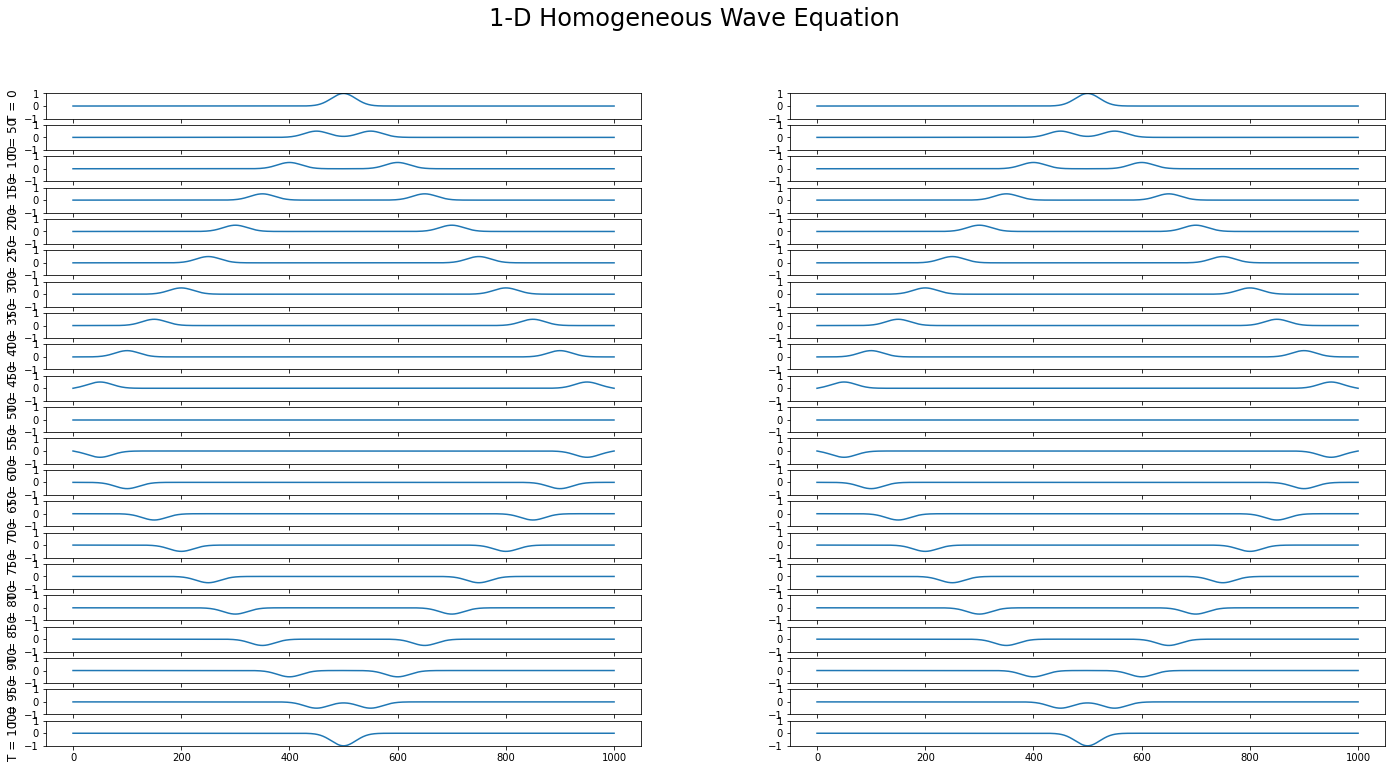

In [ ]:
# run this to visualize the wave equation - each simulation will be stacked side-by-side
rows = 21
viz(rows, SOLUTION_SPACE)

## 3) Heterogeneous materials

The same code above can be slightly modified to investigate the evolution of the displacement field time series, when

1. $c(x)=1,\; \rho(x)=1,\; \kappa(x)=1 \quad (x\in[0,60])$
2. $c(x)=2,\; \rho(x)=1,\; \kappa(x)=4 \quad (x\in(60,100])$

using the same initial conditions than previously, and the Dirichlet boundary conditions in $x=0$ and the Neumann boundary conditions in $x=100$.

## To Be Continued

In [ ]:
# # def vizualize(
# #     c, k, p, L, dt, dx, C, T, DOMAIN, bounds,       # variables necessary to run the solver
# #     animate=True):                                  # animate the simulation

# #     class PlotMatplotlib:                           # future iterations will potentially use Bokeh plotting so I'm future proofing this, otherwise this is unnecessary
# #         def __call__(self, solution_space, u, x, t, n):
# #             """ Version 1 of this class """
# #             if n == 0:
# #                 plt.ion()
# #                 self.lines = plt.plot(x, u, 'r-')
# #                 plt.xlabel('x'); plt.ylabel('u')
# #                 plt.axis([0, L, solution_space.min(), solution_space.max()])
# #                 plt.legend(['t=%f' % t[n]], loc='lower left')
# #             else:
# #                 self.lines[0].set_ydata(u)
# #                 plt.legend(['t=%f' % t[n]], loc='lower left')
# #                 plt.draw()
# #             time.sleep(2) if t[n] == 0 else time.sleep(0.2)
# #             plt.savefig('tmp_04%d.png' % n)         # saves figures to compile into a movie
    
#     # Run the simulation



# rows, cols = 6, 1
# fig = plt.figure(figsize=(24,12))#, sharex=True, sharey=True)
# spec = fig.add_gridspec(nrows=rows, ncols=cols, wspace=.25, hspace=.25)
# plt.suptitle('1-D Homogeneous Wave Equation', fontsize=24, x=.5)
# # fig.text(.5,.925,'1D Heat Equation', fontsize=18, ha='center')

# for row in range(rows):
#     for col in range(cols):
#         ax = fig.add_subplot(spec[row,col])
#         ax.plot(sol_space_1[col,:,row*20])
#         plt.ylim(,T_spike)
#         # plt.legend(['T = %d' % (row*20)])
#         if col == 0:
#             plt.ylabel('T = {}'.format(row*20), fontsize=12)
#         if row == 0:
#             ax.set_title(r'$\Delta \, t = %.2f \, \frac{\Delta x^2}{D}$' % (dt[col]), fontsize=16)

# # for ax in fig.get_axes():
# #     ax.label_outer()
# plt.show()